In [1]:
from collections import Counter
import string
import re
import argparse
import json
import sys
import numpy as np
import nltk
import random
import math
import os
import pickle
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import torch

In [2]:
in_pkl_path = "./"
pred_pkl_name = "bi_att_predictions_no_tf.pkl"
gt_pkl_name = "../data/coqa/preprocessed_dev_no_tf.pkl"

In [3]:
def pickler(path,pkl_name,obj):
    with open(os.path.join(path, pkl_name), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def unpickler(path,pkl_name):
    with open(os.path.join(path, pkl_name) ,'rb') as f:
        obj = pickle.load(f)
    return obj

In [4]:
dev_data = unpickler(in_pkl_path,gt_pkl_name)

In [5]:
dev_data.keys()

dict_keys(['passages_word', 'passages_char', 'questions_word', 'questions_char', 'answers_word', 'answers_char', 'histories_word', 'histories_char', 'supporting_facts', 'unpadded_question_lengths', 'unpadded_passage_lengths', 'unpadded_answer_lengths', 'data_points', 'turn_ids', 'questions_word_unpadded', 'questions_char_unpadded', 'separator_id'])

In [6]:
len(dev_data['supporting_facts'][100])

25

In [7]:
gt = dev_data["supporting_facts"]

In [8]:
len(gt)

7983

In [9]:
gt_classes = np.array(gt).argmax(axis=1)

In [10]:
gt_classes[:15]

array([ 0,  0,  2,  3,  6,  7,  9,  9, 10, 15, 17, 14,  0,  4,  8])

In [11]:
gt_classes.shape

(7983,)

In [12]:
predictions = unpickler(in_pkl_path,pred_pkl_name)

In [13]:
predictions.shape

(7983, 25)

In [14]:
predictions[0]

array([  7.4891295,   2.8007386,   6.0215797,  -2.5203133,   4.780283 ,
         4.5949507,   6.4152956,   5.640228 ,  -3.380505 ,   7.090777 ,
        -4.9287868,   3.6729574,  -5.3263607,   6.060643 ,  -5.174132 ,
         5.4010873,   6.666089 ,   6.2652636,   3.7104907,   4.960864 ,
        -2.5211742, -10.167487 , -10.167487 , -10.167487 , -10.167487 ],
      dtype=float32)

In [15]:
predictions_softmaxed = torch.softmax(torch.tensor(predictions), dim=-1).numpy()

In [16]:
predictions_softmaxed[0]

array([2.6640037e-01, 2.4512783e-03, 6.1402496e-02, 1.1980883e-05,
       1.7745888e-02, 1.4743783e-02, 9.1027930e-02, 4.1934069e-02,
       5.0688855e-06, 1.7886792e-01, 1.0777110e-06, 5.8639776e-03,
       7.2416566e-07, 6.3848555e-02, 8.4323818e-07, 3.3014871e-02,
       1.1697496e-01, 7.8345954e-02, 6.0882550e-03, 2.1258034e-02,
       1.1970582e-05, 5.7195759e-09, 5.7195759e-09, 5.7195759e-09,
       5.7195759e-09], dtype=float32)

In [17]:
#Sorting in decending order of scores
predictions_arg_sorted = (-predictions).argsort()

In [18]:
predictions_arg_sorted.shape

(7983, 25)

In [19]:
predictions_arg_sorted[0]

array([ 0,  9, 16,  6, 17, 13,  2,  7, 15, 19,  4,  5, 18, 11,  1,  3, 20,
        8, 10, 14, 12, 21, 22, 23, 24])

Avg number of sentences per passage in coqa = 15

In [20]:
print(min(dev_data['turn_ids']))
print(max(dev_data['turn_ids']))

1
25


Turn IDs start from 1. Convert them to 0 based by subtracting 1 to save pain later

In [21]:
zero_based_turn_id = [t-1 for t in dev_data['turn_ids']]

In [22]:
print(min(zero_based_turn_id))
print(max(zero_based_turn_id))

0
24


In [23]:
turn_id_buckets = [[] for i in range(max(zero_based_turn_id) + 1)]

In [24]:
len(turn_id_buckets)

25

Segregate data indices into buckets based on turn ID

In [25]:
for i,t_id in enumerate(zero_based_turn_id):
    turn_id_buckets[t_id].append(i)

# Recall@k

## Turn_ID vs number of questions

In [26]:
turn_vs_count_df = pd.DataFrame(data={"Turn_ID":list(range(max(zero_based_turn_id) + 1)), 
                                      "Number_of_questions":[len(x) for x in turn_id_buckets]})

In [27]:
turn_vs_count_df.head()

,Turn_ID,Number_of_questions
0,0,500
1,1,500
2,2,500
3,3,500
4,4,500


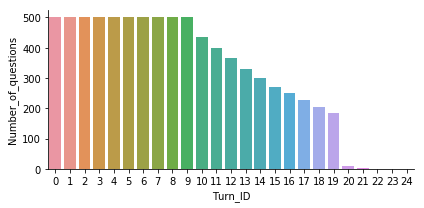

In [28]:
sns.catplot(x="Turn_ID", y="Number_of_questions", kind='bar', data=turn_vs_count_df, height=3, aspect=2)

## Turn_ID vs Accuracy

In [29]:
turn_vs_accuracy = []
for bucket in turn_id_buckets:
    num_correct = 0
    bucket_size = len(bucket)
    for data_index in bucket:
        if(predictions_arg_sorted[data_index][0] == gt_classes[data_index]):
            num_correct += 1
    turn_vs_accuracy.append(num_correct/bucket_size)

In [30]:
turn_vs_accuracy_df = pd.DataFrame(data={"Turn_ID":list(range(max(zero_based_turn_id) + 1)), 
                                      "Accuracy":turn_vs_accuracy})

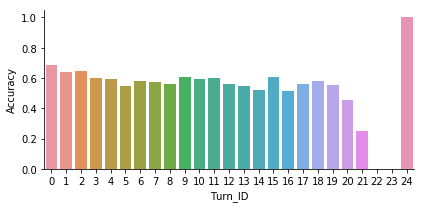

In [31]:
sns.catplot(x="Turn_ID", y="Accuracy", kind='bar', data=turn_vs_accuracy_df, height=3, aspect=2)

## Turn_ID vs answer ranks

In [32]:
answer_ranks = []
for i,gt in enumerate(gt_classes):
    rank = predictions_arg_sorted[i].tolist().index(gt)
    answer_ranks.append(rank)
assert(len(answer_ranks) == len(zero_based_turn_id))

In [33]:
turn_vs_ans_rank_df = pd.DataFrame(data={"Turn_ID":zero_based_turn_id, "Answer_rank":answer_ranks})

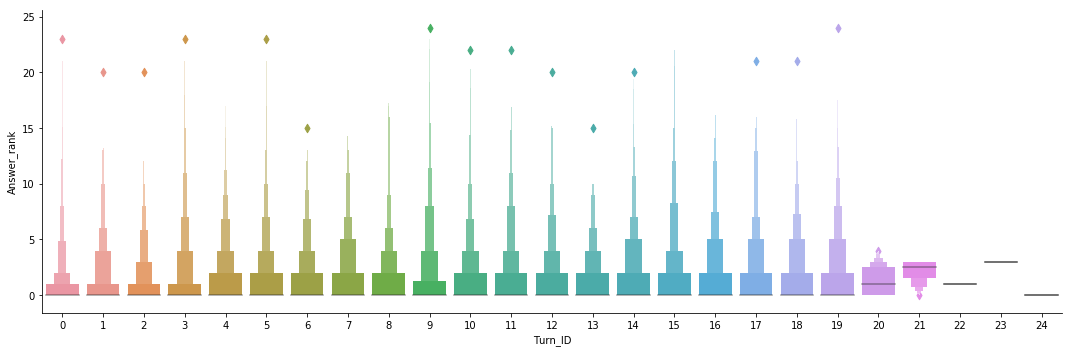

In [34]:
sns.catplot(x="Turn_ID", y="Answer_rank", kind='boxen', data=turn_vs_ans_rank_df, height=5, aspect=3)

## Turd_ID vs mean answer rank

In [35]:
mean_ans_ranks = []
for bucket in turn_id_buckets:
    ranks = []
    for data_index in bucket:
        ranks.append(answer_ranks[data_index])
    mean_rank = np.array(ranks).mean()
    mean_ans_ranks.append(mean_rank)

In [36]:
turn_vs_mean_ans_rank_df = pd.DataFrame(data={"Turn_ID":list(range(max(zero_based_turn_id) + 1)), "Mean_answer_rank":mean_ans_ranks})

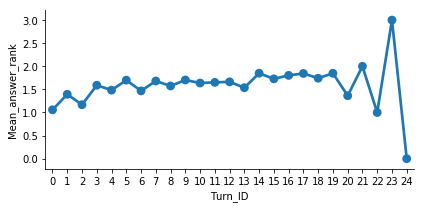

In [37]:
sns.catplot(x="Turn_ID", y="Mean_answer_rank", kind='point', data=turn_vs_mean_ans_rank_df, height=3, aspect=2)

Vertical lines = confidence intervals (0.95)

/home/bhargav/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


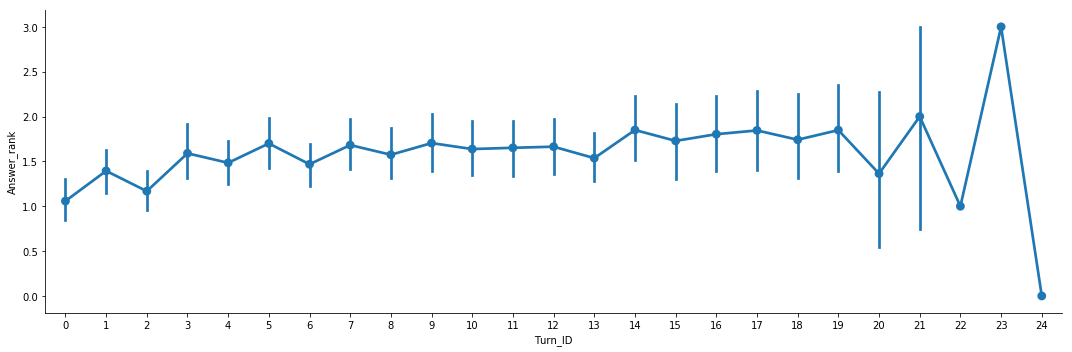

In [38]:
sns.catplot(x="Turn_ID", y="Answer_rank", kind='point', data=turn_vs_ans_rank_df, height=5, aspect=3)

Vertical lines = standard deviation

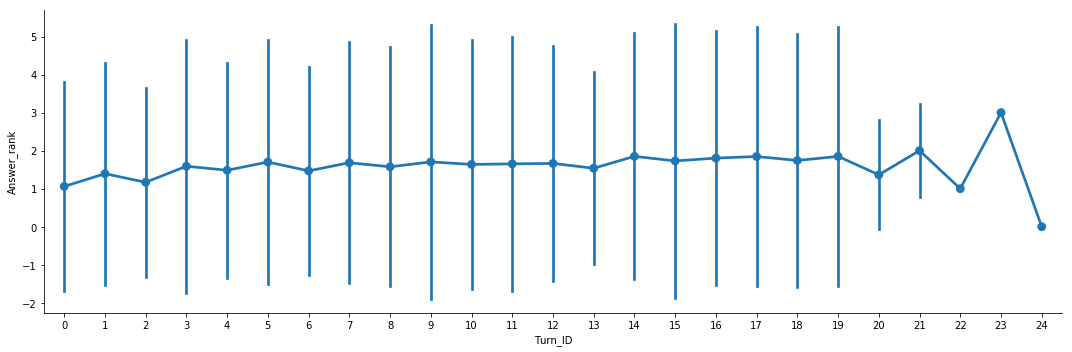

In [39]:
sns.catplot(x="Turn_ID", y="Answer_rank", kind='point', data=turn_vs_ans_rank_df, height=5, aspect=3, ci='sd')

In [40]:
grouped_ranks = []
for rank in answer_ranks:
    cat = "Other"
    if(rank == 0):
        cat = "0"
    elif(rank == 1):
        cat = "1"
    elif(rank == 2):
        cat = "2"
    elif(rank == 3):
        cat = "3"
    grouped_ranks.append(cat)

In [41]:
turn_vs_rank_cat = [[] for i in range(max(zero_based_turn_id) + 1)]
for i,rank in enumerate(grouped_ranks):
    turn_id = zero_based_turn_id[i]
    turn_vs_rank_cat[turn_id].append(rank)
    

In [42]:
t_ids = []
rank_categories = []
fractions = []
for i,bucket in enumerate(turn_vs_rank_cat):
    unique, counts = np.unique(bucket, return_counts=True)
    frac = dict(zip(unique, counts/len(bucket)))
#     print("==============")
#     print(i,frac)
#     print("==============")
    for key,value in frac.items():
        t_ids.append(i)
        rank_categories.append(key)
        fractions.append(value)
        
assert(len(t_ids) == len(rank_categories) == len(fractions))

In [43]:
print(t_ids[:10])
print(rank_categories[:10])
print(fractions[:10])

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
['0', '1', '2', '3', 'Other', '0', '1', '2', '3', 'Other']
[0.688, 0.132, 0.064, 0.032, 0.084, 0.638, 0.12, 0.07, 0.042, 0.13]


In [44]:
turn_vs_rank_cat_df = pd.DataFrame(data={'Turn_ID':t_ids, 'Rank_categories':rank_categories, 'Fractions':fractions})

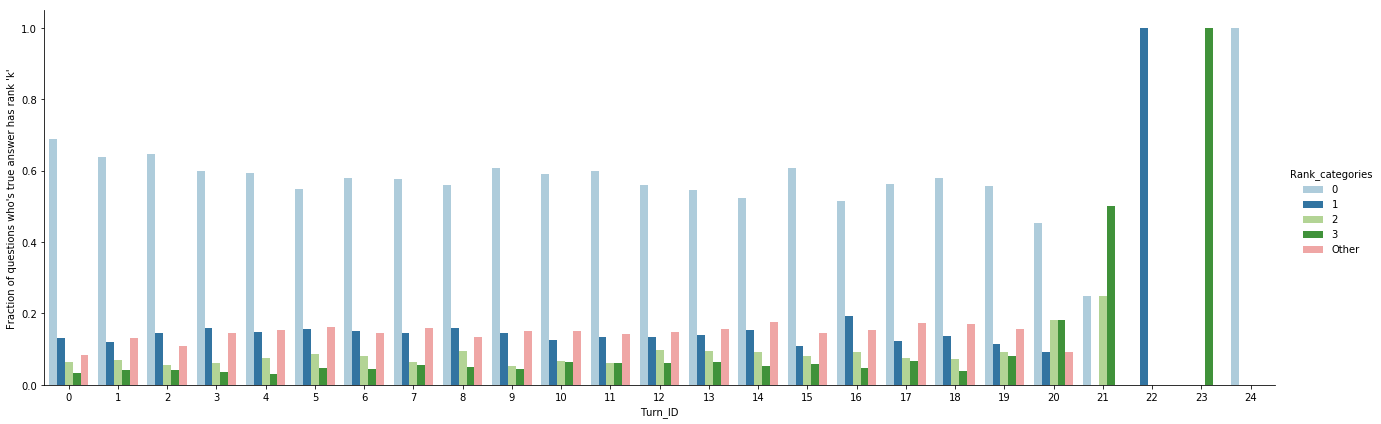

In [45]:
p = sns.catplot(x="Turn_ID", y="Fractions", hue="Rank_categories", data=turn_vs_rank_cat_df,
                height=6, aspect=3, kind="bar", palette="Paired", hue_order=['0','1','2','3','Other'])
p.set_ylabels("Fraction of questions who's true answer has rank 'k'")

# Examining sentence scores

In [46]:
# considering only the first 20 turns because after that answer_ranks[index] > 1 isn't true for all questions 
# for some turn_id > 20

avg_first_minus_second_rank0 = []
avg_first_minus_second_rank1 = []

for i in range(20):
    bucket = turn_id_buckets[i]
    score_differences_correct = []
    score_differences_incorrect = []
    for index in bucket:
        if(answer_ranks[index] > 1):
            continue
        s0_index = predictions_arg_sorted[index][0]
        s1_index = predictions_arg_sorted[index][1]
        s0 = predictions_softmaxed[index][s0_index]
        s1 = predictions_softmaxed[index][s1_index]
        difference = s0 - s1
        if(answer_ranks[index] == 0):
            score_differences_correct.append(difference)
        elif(answer_ranks[index] == 1):
            score_differences_incorrect.append(difference)
    
    if(len(score_differences_correct) != 0 and len(score_differences_incorrect) != 0):
        avg_difference_correct = np.mean(score_differences_correct)
        avg_difference_incorrect = np.mean(score_differences_incorrect)
        
        avg_first_minus_second_rank0.append(avg_difference_correct)
        avg_first_minus_second_rank1.append(avg_difference_incorrect)
    else:
        print("Skipped turn_id:{}".format(i))
        continue
    
    


## Difference in scores between the first and the second ranked sentences when the ture answer is in first rank

In [47]:
turn_vs_relative_diff_correct_df = pd.DataFrame(data={'Turn_ID':list(range(20)), 'Mean_Score_Differences':avg_first_minus_second_rank0})

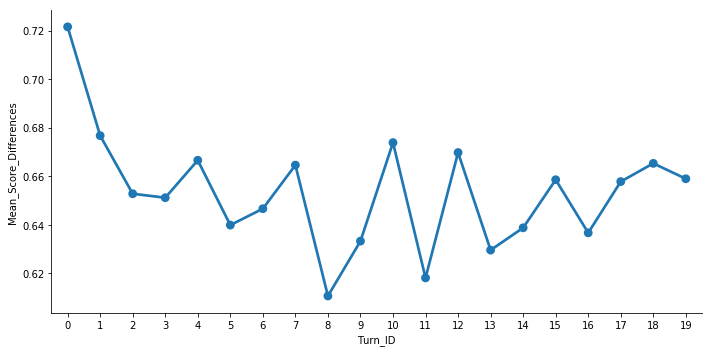

In [48]:
sns.catplot(x="Turn_ID", y="Mean_Score_Differences", kind='point', data=turn_vs_relative_diff_correct_df, height=5, aspect=2)

## Difference in scores between the first and the second ranked sentences when the ture answer is in second rank

In [49]:
turn_vs_relative_diff_incorrect_df = pd.DataFrame(data={'Turn_ID':list(range(20)), 'Mean_Score_Differences':avg_first_minus_second_rank1})

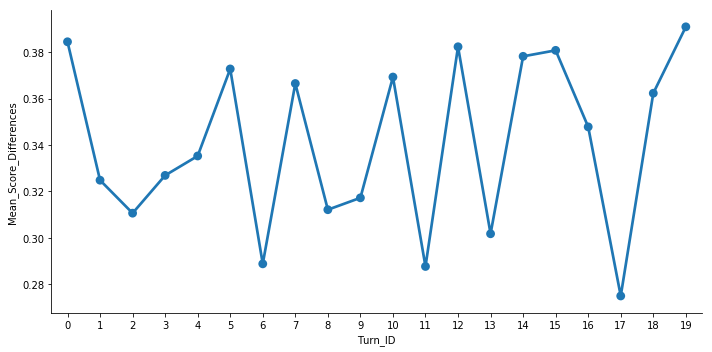

In [50]:
sns.catplot(x="Turn_ID", y="Mean_Score_Differences", kind='point', data=turn_vs_relative_diff_incorrect_df, height=5, aspect=2)

## By how much was the first rank missed?

In [51]:
score_differences = []
for index in range(len(predictions_softmaxed)):
    ans_rank = answer_ranks[index]
    if(ans_rank == 0):
        score_differences.append(0)
    else:
        s0_index = predictions_arg_sorted[index][0]
        sk_index = predictions_arg_sorted[index][ans_rank]
        s0 = predictions_softmaxed[index][s0_index]
        sk = predictions_softmaxed[index][sk_index]
        difference = s0 - sk
        score_differences.append(difference)

In [52]:
score_differences[:10]

[0, 0, 0.39256772, 0, 0, 0.74679303, 0.18555348, 0, 0.20258713, 0.5392049]

In [53]:
turn_vs_avg_score_differences_incorrect = []
for bucket in turn_id_buckets[:20]:
    scores = []
    for index in bucket:
        if(answer_ranks[index] != 0):
            scores.append(score_differences[index])
    mean_diff = np.mean(scores)
    turn_vs_avg_score_differences_incorrect.append(mean_diff)

In [54]:
turn_vs_avg_score_differences_incorrect_df = pd.DataFrame(data={'Turn_ID':list(range(20)), 'Mean_Score_Differences':turn_vs_avg_score_differences_incorrect})

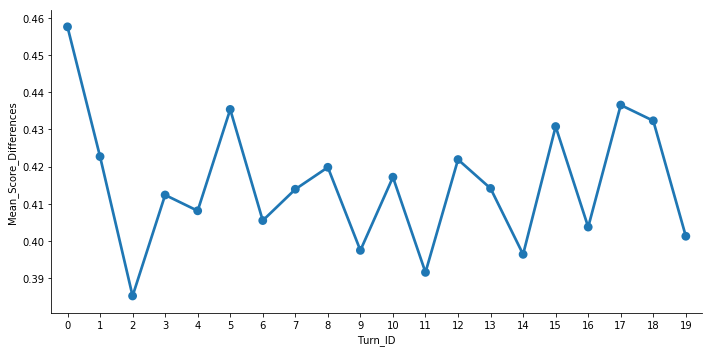

In [55]:
sns.catplot(x="Turn_ID", y="Mean_Score_Differences", kind='point', data=turn_vs_avg_score_differences_incorrect_df, 
            height=5, aspect=2)

# Examples

In [56]:
text_data = unpickler(in_pkl_path, "../data/coqa/dataset_formatted_dev.pkl")

In [57]:
text_data.keys()

dict_keys(['passages', 'questions', 'answer_spans', 'answer_sentences', 'data_points', 'turn_ids', 'histories'])

In [58]:
def get_formatted_example(data, predictions, index):
    passage_id, question_id, prev_qa_ids = data["data_points"][index]
    scores = predictions[index]
    turn_id = data["turn_ids"][index]
    passage_sents = []
    for i in range(len(data["passages"][passage_id])):
        if(i < len(scores)):
            sent = [scores[i]]+[" ".join(data["passages"][passage_id][i])]
        else:
            sent = ["---Truncated---"]+[" ".join(data["passages"][passage_id][i])]
        passage_sents.append(sent)
    current_question = " ".join(data["questions"][question_id])
    current_correct_answer = " ".join(data["answer_spans"][question_id])
    current_prediction = passage_sents[np.argmax(predictions[index])]
    
    question_i_1 = " ".join(data["questions"][prev_qa_ids[-1]])
    correct_answer_i_1 = " ".join(data["answer_spans"][prev_qa_ids[-1]])
    prediction_i_1 = passage_sents[np.argmax(predictions[index-1])][1]
        
    question_i_2 = " ".join(data["questions"][prev_qa_ids[-2]])
    correct_answer_i_2 = " ".join(data["answer_spans"][prev_qa_ids[-2]])
    prediction_i_2 = passage_sents[np.argmax(predictions[index-2])][1]

    
    print("====== Passage (id:{}) ======".format(passage_id))
    for sent in passage_sents:
        print(sent)
    print()
    if(turn_id > 2):
        print("====== History i-2 ======")
        print("Question: ")
        print(question_i_2)
        print()
        print("True answer: ")
        print(correct_answer_i_2)
        print()
        print("Prediction: ")
        print(prediction_i_2)
        print()
    if(turn_id > 1):
        print("====== History i-1 ======")
        print("Question: ")
        print(question_i_1)
        print()
        print("True answer: ")
        print(correct_answer_i_1)
        print()
        print("Prediction: ")
        print(prediction_i_1)
        print()
    print("====== Current turn. Turn_ID:{} ======".format(turn_id))
    print("Question: ")
    print(current_question)
    print()
    print("True answer: ")
    print(current_correct_answer)
    print()
    print("Prediction: ")
    print(current_prediction)
    print()

## Incorrect with highest score difference

In [59]:
index = np.argmax(score_differences)

In [60]:
score_differences[index]

0.9999338

In [61]:
get_formatted_example(data=text_data,predictions=predictions_softmaxed, index=index)

====== Passage (id:286) ======
[1.6266033e-06, 'the russian soviet federative socialist republic russian sfsr or rsfsr russian российская советская федеративная социалистическая республика , tr .']
[2.1095934e-06, 'rossiyskaya sovetskaya federativnaya sotsialisticheskaya respublika listen help·info commonly referred to as soviet russia or simply as russia , was a sovereign state in 1917–22 , the largest , most populous , and most economically developed republic of the soviet union in 1922–91 and a sovereign part of the soviet union with its own legislation in 1990–91 .']
[0.99996483, 'the republic comprised sixteen autonomous republics , five autonomous oblasts , ten autonomous okrugs , six krais , and forty oblasts .']
[2.429124e-07, 'russians formed the largest ethnic group .']
[1.5229277e-07, 'to the west it bordered finland , norway and poland and to the south , china , mongolia and north korea whilst bordering the arctic ocean to the north , the pacific ocean to the east and the b

## Incorrect with lowest score difference

In [62]:
fake_score_differences = []

In [63]:
for item in score_differences:
    if item < 1e-40:
        fake_score_differences.append(999)
    else:
        fake_score_differences.append(item)

In [64]:
index = np.argmin(fake_score_differences)

In [65]:
fake_score_differences[index]

4.659593e-05

In [66]:
get_formatted_example(data=text_data,predictions=predictions_softmaxed, index=index)

====== Passage (id:367) ======
[0.16183846, 'chapter xxiii a slide down the mountain side my gracious , dick it sure is snowing some now yes , and it is getting colder every minute .']
[0.07266344, "if we do n't get out of the mountains putty quick we 'll be snowed in , came from jack wumble ."]
[0.030047962, 'did you calkerlate to git back to dawson afore winter sot in ?']
[0.0022239697, 'inquired ike furner , curiously .']
[0.009992634, 'why of course cried sam .']
[0.013749057, "i do n't see how you are goin' to make it ."]
[0.011011956, 'oh , we must get back , said dick .']
[0.008093914, 'if only we could find tom , he added , with a sigh .']
[0.015427057, 'it was fully an hour after they had left the campfire at the entrance to the cave of the mountain .']
[0.04382371, 'they had walked to the chasm where they thought tom might have had a tumble and crossed and recrossed it several times .']
[0.035822626, 'but they had found no traces of the missing rover boy .']
[0.038611013, 'if

## Correct prediction

In [67]:
index = np.argmin(score_differences[3:]) + 3

In [68]:
index

3

In [69]:
get_formatted_example(data=text_data,predictions=predictions_softmaxed, index=index)

====== Passage (id:0) ======
[0.36899853, 'once upon a time , in a barn near a farm house , there lived a little white kitten named cotton .']
[0.01995678, "cotton lived high up in a nice warm place above the barn where all of the farmer 's horses slept ."]
[0.0027031195, "but cotton was n't alone in her little home above the barn , oh no ."]
[0.5835154, 'she shared her hay bed with her mommy and 5 other sisters .']
[0.001842711, 'all of her sisters were cute and fluffy , like cotton .']
[0.00022601699, 'but she was the only white one in the bunch .']
[0.0059579015, "the rest of her sisters were all orange with beautiful white tiger stripes like cotton 's mommy ."]
[3.0543575e-05, 'being different made cotton quite sad .']
[0.0016839108, 'she often wished she looked like the rest of her family .']
[0.0013021813, "so one day , when cotton found a can of the old farmer 's orange paint , she used it to paint herself like them ."]
[0.011622367, 'when her mommy and sisters found her they st